In this notebook, we will build a 3D map of a scene from a small set of images.

In [2]:
%load_ext autoreload
%autoreload 2
import tqdm, tqdm.notebook
tqdm.tqdm = tqdm.notebook.tqdm  # notebook-friendly progress bars
from pathlib import Path
import numpy as np

from hloc import extract_features, match_features, reconstruction, visualization, pairs_from_exhaustive
from hloc.visualization import plot_images, read_image
from hloc.utils import viz_3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Setup
Here we define some output paths.

In [3]:
obj_name = "shoe"

images = Path(f'datasets/{obj_name}')
outputs = Path(f'outputs/{obj_name}/')
!rm -rf $outputs
sfm_pairs = outputs / 'pairs-sfm.txt'
loc_pairs = outputs / 'pairs-loc.txt'
sfm_dir = outputs / 'sfm'
features = outputs / 'features.h5'
matches = outputs / 'matches.h5'

pcd_save_path = sfm_dir
cam_dir = outputs / "cam"

feature_conf = extract_features.confs['disk']
matcher_conf = match_features.confs['disk+lightglue']

# 3D mapping
First we list the images used for mapping. These are all no-flash images.

40 mapping images


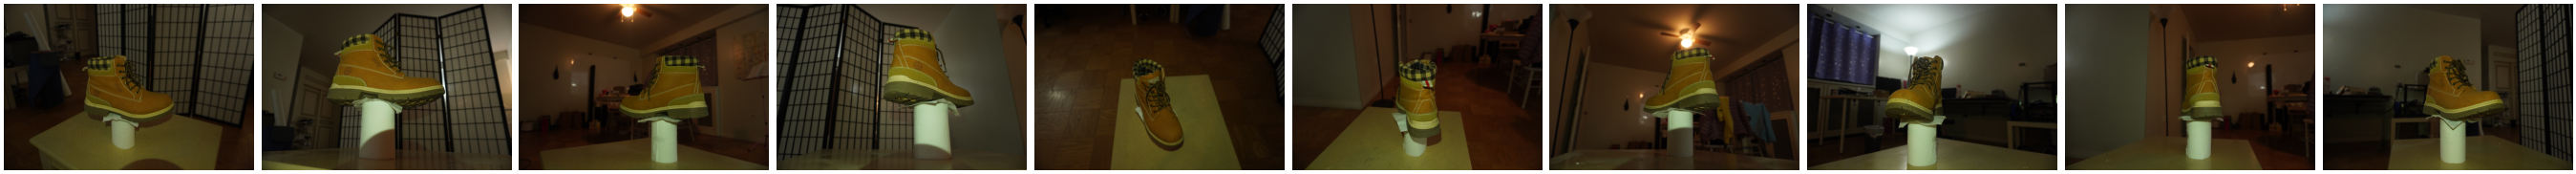

In [4]:
references = [p.relative_to(images).as_posix() for p in (images / 'flash/').iterdir()]
print(len(references), "mapping images")
plot_images([read_image(images / r) for r in references[:10]], dpi=40)

Then we extract features and match them across image pairs. Since we deal with few images, we simply match all pairs exhaustively. For larger scenes, we would use image retrieval, as demonstrated in the other notebooks.

In [5]:
extract_features.main(feature_conf, images, image_list=references, feature_path=features)
pairs_from_exhaustive.main(sfm_pairs, image_list=references)
match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches);

[2023/12/18 19:21:25 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 5000, 'name': 'disk'},
 'output': 'feats-disk',
 'preprocessing': {'grayscale': False, 'resize_max': 1600}}


  0%|          | 0/40 [00:00<?, ?it/s]

[2023/12/18 19:21:43 hloc INFO] Finished exporting features.
[2023/12/18 19:21:43 hloc INFO] Found 780 pairs.
[2023/12/18 19:21:43 hloc INFO] Matching local features with configuration:
{'model': {'features': 'disk', 'name': 'lightglue'},
 'output': 'matches-disk-lightglue'}
/home/tina/anaconda3/envs/dl_dev/lib/python3.8/site-packages/lightglue/lightglue.py:141: UserWarning: FlashAttention is not available. For optimal speed, consider installing torch >= 2.0 or flash-attn.
  self.inner_attn = Attention(flash)


  0%|          | 0/780 [00:00<?, ?it/s]

[2023/12/18 19:24:51 hloc INFO] Finished exporting matches.


The we run incremental Structure-From-Motion and display the reconstructed 3D model.

In [6]:
model = reconstruction.main(sfm_dir, images, sfm_pairs, features, matches, image_list=references)

[2023/12/18 19:26:00 hloc INFO] Creating an empty database...


[2023/12/18 19:26:00 hloc INFO] Importing images into the database...
[2023/12/18 19:26:01 hloc INFO] Importing features into the database...


  0%|          | 0/40 [00:00<?, ?it/s]

[2023/12/18 19:26:01 hloc INFO] Importing matches into the database...


  0%|          | 0/780 [00:00<?, ?it/s]

[2023/12/18 19:26:01 hloc INFO] Performing geometric verification of the matches...
[2023/12/18 19:26:02 hloc INFO] Running 3D reconstruction...
[2023/12/18 19:26:34 hloc INFO] Reconstructed 1 model(s).
[2023/12/18 19:26:34 hloc INFO] Largest model is #0 with 38 images.
[2023/12/18 19:26:34 hloc INFO] Reconstruction statistics:
Reconstruction:
	num_reg_images = 38
	num_cameras = 38
	num_points3D = 12545
	num_observations = 62960
	mean_track_length = 5.01873
	mean_observations_per_image = 1656.84
	mean_reprojection_error = 1.22432
	num_input_images = 40


In [7]:
fig = viz_3d.init_figure()
viz_3d.plot_reconstruction(fig, model, color='rgba(255,0,0,0.5)', name="mapping", points_rgb=True, pcd_save_path = pcd_save_path)
fig.show()

original point cloud shape: (12473, 3)


In [8]:
viz_3d.save_cameras(model, save_camera_path=cam_dir)

Saving cameras to outputs/shoe/cam


  0%|          | 0/38 [00:00<?, ?it/s]

We also visualize which keypoints were triangulated into the 3D model.

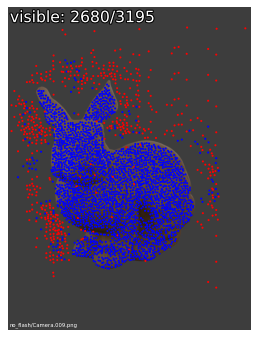

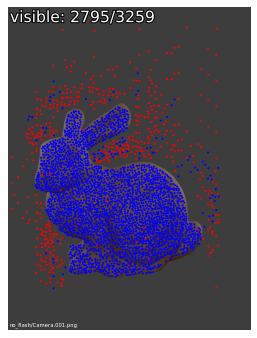

In [14]:
visualization.visualize_sfm_2d(model, images, color_by='visibility', n=2)

# Localization
Now that we have a 3D map of the scene, we can localize any image. To demonstrate this, we download [a night-time image from Wikimedia](https://commons.wikimedia.org/wiki/File:Paris_-_Basilique_du_Sacr%C3%A9_Coeur,_Montmartre_-_panoramio.jpg).

In [ ]:
url = "https://upload.wikimedia.org/wikipedia/commons/5/53/Paris_-_Basilique_du_Sacr%C3%A9_Coeur%2C_Montmartre_-_panoramio.jpg"
# try other queries by uncommenting their url
# url = "https://upload.wikimedia.org/wikipedia/commons/5/59/Basilique_du_Sacr%C3%A9-C%C5%93ur_%285430392880%29.jpg"
# url = "https://upload.wikimedia.org/wikipedia/commons/8/8e/Sacr%C3%A9_C%C5%93ur_at_night%21_%285865355326%29.jpg"
query = 'query/night.jpg'
!mkdir -p $images/query && wget $url -O $images/$query -q
plot_images([read_image(images / query)], dpi=75)

Again, we extract features for the query and match them exhaustively.

In [ ]:
extract_features.main(feature_conf, images, image_list=[query], feature_path=features, overwrite=True)
pairs_from_exhaustive.main(loc_pairs, image_list=[query], ref_list=references)
match_features.main(matcher_conf, loc_pairs, features=features, matches=matches, overwrite=True);

We read the EXIF data of the query to infer a rough initial estimate of camera parameters like the focal length. Then we estimate the absolute camera pose using PnP+RANSAC and refine the camera parameters.

In [ ]:
import pycolmap
from hloc.localize_sfm import QueryLocalizer, pose_from_cluster

camera = pycolmap.infer_camera_from_image(images / query)
ref_ids = [model.find_image_with_name(r).image_id for r in references]
conf = {
    'estimation': {'ransac': {'max_error': 12}},
    'refinement': {'refine_focal_length': True, 'refine_extra_params': True},
}
localizer = QueryLocalizer(model, conf)
ret, log = pose_from_cluster(localizer, query, camera, ref_ids, features, matches)

print(f'found {ret["num_inliers"]}/{len(ret["inliers"])} inlier correspondences.')
visualization.visualize_loc_from_log(images, query, log, model)

We visualize the correspondences between the query images a few mapping images. We can also visualize the estimated camera pose in the 3D map.

In [ ]:
pose = pycolmap.Image(tvec=ret['tvec'], qvec=ret['qvec'])
viz_3d.plot_camera_colmap(fig, pose, camera, color='rgba(0,255,0,0.5)', name=query, fill=True)
# visualize 2D-3D correspodences
inl_3d = np.array([model.points3D[pid].xyz for pid in np.array(log['points3D_ids'])[ret['inliers']]])
viz_3d.plot_points(fig, inl_3d, color="lime", ps=1, name=query)
fig.show()